# Решение команды Provinciya для кейса "В продакшен - зарплата", хакатона ИИ Омск. Раздел: Предсказание зарплаты

## Вступительная база

### Установка модулей

In [1]:
#pip install shap

In [2]:
#pip install lime

### Подключение библиотек

In [3]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.inspection import permutation_importance
import shap
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime
import json
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import shap
from transformers import AutoTokenizer, AutoModel
import re
from html import unescape
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MultiLabelBinarizer

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Изменим настройки отображения вывода Pandas

In [4]:
pd.set_option('display.max_columns', 1500)
pd.set_option('display.max_rows', 1500)

## Считывание и исследование таблицы. Подготовка плана

### Загрузим таблицу и проведем первичное исследование

In [5]:
df = pd.read_csv('TRAIN_SAL.csv', encoding='UTF-8')

/tmp/ipykernel_36680/3207862701.py:1: DtypeWarning: Columns (1,16,24,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('TRAIN_SAL.csv', encoding='UTF-8')


In [6]:
df.columns

Index(['id', 'academic_degree', 'accommodation_capability',
       'accommodation_type', 'additional_premium', 'additional_requirements',
       'bonus_type', 'measure_type', 'busy_type', 'career_perspective',
       'change_time', 'code_external_system', 'code_profession',
       'code_professional_sphere', 'company_code', 'contact_person',
       'contact_source', 'data_ids', 'date_create', 'date_modify', 'deleted',
       'education', 'education_speciality', 'foreign_workers_capability',
       'metro_ids', 'is_mobility_program', 'is_moderated',
       'is_uzbekistan_recruitment', 'is_quoted', 'need_medcard', 'oknpo_code',
       'okso_code', 'original_source_type', 'other_vacancy_benefit',
       'position_requirements', 'position_responsibilities',
       'publication_period', 'published_date', 'regionName', 'regionNameTerm',
       'company_business_size', 'required_certificates',
       'required_drive_license', 'required_experience',
       'retraining_capability', 'retraining_

In [7]:
df.shape

(631117, 78)

In [8]:
df.isna().sum()

id                                      0
academic_degree                    630830
accommodation_capability                0
accommodation_type                 597838
additional_premium                 549987
additional_requirements            400830
bonus_type                         549481
measure_type                       549778
busy_type                               0
career_perspective                      0
change_time                          5001
code_external_system               555416
code_profession                     14958
code_professional_sphere               14
company_code                            0
contact_person                        108
contact_source                     568063
data_ids                                0
date_create                             0
date_modify                             0
deleted                                 0
education                               0
education_speciality               515614
foreign_workers_capability        

In [9]:
df.describe()

,additional_premium,code_profession,foreign_workers_capability,oknpo_code,okso_code,publication_period,regionNameTerm,required_experience,retraining_condition,retraining_grant_value,salary,salary_min,salary_max,state_region_code,vacancy_address_code,vacancy_address_latitude,vacancy_address_longitude,work_places,federalDistrictCode,contactList,company_name,company_inn
count,8.113000e+04,616159.000000,0.0,0.0,2.131900e+04,631101.0,0.0,619834.000000,0.0,1832.000000,631117.000000,631117.000000,625610.000000,6.311150e+05,6.311150e+05,629449.000000,629449.000000,631117.000000,631115.000000,0.0,0.0,6.308380e+05
mean,3.328676e+03,204371.592777,NaN,NaN,4.562951e+06,0.0,NaN,0.723607,NaN,24809.788210,38384.735822,38384.735822,26779.914416,4.727941e+12,4.138854e+16,53.937706,57.976764,3.032835,3.832233,NaN,NaN,1.992434e+10
std,1.497278e+04,54226.454292,NaN,NaN,2.014522e+06,0.0,NaN,1.340470,NaN,12830.891459,24428.689280,24428.689280,33758.035176,2.329277e+12,2.699732e+16,5.142206,28.793794,19.488395,2.039781,NaN,NaN,9.012754e+10
min,0.000000e+00,21687.000000,NaN,NaN,2.801010e+05,0.0,NaN,0.000000,NaN,39.000000,0.000000,0.000000,0.000000,1.000000e+11,1.000000e+11,26.430880,-179.478320,0.000000,1.000000,NaN,NaN,1.000000e+08
25%,2.500000e+01,167815.000000,NaN,NaN,2.230503e+06,0.0,NaN,0.000000,NaN,19242.000000,22544.000000,22544.000000,0.000000,2.600000e+12,2.200900e+16,51.523359,38.918638,1.000000,2.000000,NaN,NaN,2.808019e+09
50%,4.500000e+01,201908.000000,NaN,NaN,5.380201e+06,0.0,NaN,0.000000,NaN,25000.000000,32000.000000,32000.000000,22129.000000,4.800000e+12,4.200001e+16,54.781649,47.224749,1.000000,4.000000,NaN,NaN,5.406015e+09
75%,1.200000e+02,240809.000000,NaN,NaN,6.440301e+06,0.0,NaN,1.000000,NaN,30000.000000,48000.000000,48000.000000,41500.000000,6.600000e+12,6.400000e+16,56.832935,65.789243,2.000000,6.000000,NaN,NaN,7.413016e+09
max,1.500000e+06,478552.000000,NaN,NaN,9.570701e+06,0.0,NaN,50.000000,NaN,250000.000000,999999.000000,999999.000000,999999.000000,9.900000e+12,9.900000e+16,73.508149,179.258310,4840.000000,9.000000,NaN,NaN,9.729062e+11


### Выводы

**Получаем следующие результаты:**
1. change_time - делаем что-то (Тимур Допиши) (проверь, что это не просто время загрузки вакансии)
2. Столбцы с id нужны для мэтчинга внутри системы и других технических систем - выделяем в отдельный список - labels, не используем для обучения 
3. Берем в работу на кодировку: [academic_degree, acommodation_capability, acommodation_type, additional_premium, code_external_system, bonus_type, measure_type, busy_type, career_perspective, code_external_system, code_profession, code_professional_sphere, company_code, education, education_speciality, foreign_workers_capability, metro_ids, is_mobility_program, is_uzbekistan_recruitment, is_quoted, need_medcard, oknpo_code, okso_code, original_source_type, other_vacancy_benefit, regionName, regionNameTerm, company_business_size, reguired_drive_license, reguired_experience, retraining_capability, retraining_condition, retraining_grant, retraining_grant_value, schedule_type, social_protected_ids, source_type, state_region_code, transport_compensation, work_places, professionalSphereName, federalDistrictCode, industryBranchName, language, required_experiencerequired_experience,required_drive_licenserequired_drive_license]
4. Рассмотрим отдельно и решим, как будем работать с этими столбцами: [additional_requirements, position_requirements, position_responsibilities,required_sertificate, status, vacancy_address_additional_info,vacancy_benefit_ids, visibility, ]
5. Гео (отдельно подумать над ними): [vacancy_address, vacancy_address_code, vacancy_address_house, vacancy_address_latitude, vacancy_address_longitude, full_company_name, company, regionNameregionName, 'state_region_code', 'federalDistrictCode',]
7. Фичи по работнику: [languageKnowledge, hardSkills, softSkills]
] - выделить смысл, попробовать помэтчить с требованиями вакансии

**Уточнения:**
1. Столбцы bonus_type, additional_premium, measure_type - нужно объединить в один признак (привести к одной единице измерения премии, мб по типу премии, привести к одному типу)
2. Подумать про работу с is_moderated
3. Подумать куда и зачем status (Мб все Rejected выбросить, типо не репрезентативно, их же не взяли)
4. Взять len(Contact_list) как фичу
5. Подтянуть данные по company_name|full_company_name к столбцу company
6. Подтянуть инфу по job_title

In [10]:
dates_feats_to_check = ['change_time', 'publication_period', 'publication_date']

In [11]:
df['status'].value_counts()

ACCEPTED          628890
WAITING             1191
REJECTED             995
AUTOMODERATION        34
CHANGED                7
Name: status, dtype: int64

In [12]:
df = df[df['status'] == 'ACCEPTED'].reset_index(drop=True)

### Исследуем фичи по работнику, и решим, что с ними делать

#### langguageKnowledge

In [13]:
df['languageKnowledge'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                           627661
[{"code_language":"Русский","id_owner":"3af8f856-8388-11ee-b151-cb26dff57dd7","level":"Базовый","type":"LanguageKnowledge"}]                                                                                                                                                                                                                                                                                                                                      1
[{"code_language":"Русский","id_owner":"5f241d06-875b-11ee-b303-295bfdef1967","level":"Базовый",

In [14]:
print('Не пустое поле знаний языка:', df.shape[0] - 629885)

Не пустое поле знаний языка: -995


#### hardSkills

In [15]:
df['hardSkills'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        572047
[{"hard_skill_name":"вежливость","owner_id":"b6e2e555-f7f7-11ee-baa5-e7d0d2cf29b1","type":"HardSkill"},{"hard_skill_name":"организованность","owner_id":"b6e2e555-f7f7-11ee-baa5-e7d0d2cf29b1","type":"HardSkill"},{"hard_skill_name":"

In [16]:
print('Не пустое поле hard skills:', df.shape[0] - 574050)

Не пустое поле hard skills: 54840


#### 'softSkills'

In [17]:
df['softSkills'].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    598567
[{"owner_id":"fb72057a-f324-11ee-9091-cb26dff57dd7","soft_skill_name":"Дисциплинированность","type":"SoftSkill"},{"owner_id":"fb72057a-f324-11ee-9091-cb26dff57dd7","soft_skill_name":"Коммуникабельность","type":"SoftSkill"},{"owner_id":

In [18]:
print('Не пустое поле soft skills:', df.shape[0] - 600674)

Не пустое поле soft skills: 28216


#### Получим количественную метрику hard и soft скилов, которые совпадают с требованиями вакансии (доделать)

In [19]:
def clean_text(text):
    if isinstance(text, str):  
        clean = re.compile('<.*?>')
        re.sub(clean, '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[✔✖️✳️✴️❗❕❓❔❕⚠️‼️⁉️🔘🔲🔳🔴🔵🔶🔷🔸🔹🔺🔻🟥🟧🟨🟩🟦🟪🟫⬛⬜️⬜️⚫⚪⚽🏀🏈⚾🎾🏐🏉🎱🎳🎮🕹️🎲🎯🎳🔧🔨⚙️⚒️🛠️⛏️⛓️⚔️🔫🧰🧲🧪🧫🧩🧠🧴🧷🧹🧻🧼🧽🧯🧰🧲🧪🧫🧩🧠🧴🧷🧹🧻🧼🧽🧯⛔✳️✨⭐🌟💫💥💦💨🕰️🕹️🗝️🗝️🔑🔒🔓🔐🔏🔎🧰🧲🧪🧫🧩🧠🧴🧷🧹🧻🧼🧽🧯⛔✳️✨⭐🌟💫💥💦💨🕰️🕹️🗝️🗝️🔑🔒🔓🔐🔏🔎🧰🧲🧪🧫🧩🧠🧴🧷🧹🧻🧼🧽🧯⛔✳️✨⭐🌟💫💥💦💨🕰️🕹️🗝️🗝️🔑🔒🔓🔐🔏🔎]' , '', text)
        text = re.sub(r'[✔\u200B-\u200D\uFEFF]', '', text) 
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'<.*?>', '', text)
        text = unescape(text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = str(text)
        return text.lower()

df['position_requirements'] = df['position_requirements'].apply(clean_text)

In [20]:
def count_hardsoft_matching(row):
    
    count_softs = 0
    count_hards = 0
    
    if pd.notna(row['softSkills']):
        try:
            soft_skills = json.loads(row['softSkills'])
            skills = [item['soft_skill_name'] for item in soft_skills if item['type'] == 'SoftSkill']
            len_soft = len(skills)
            if skills: 
                for skill in skills:
                        skill = skill.lower()
                        if isinstance(row.get('position_requirements'), str) and skill in row['position_requirements'].lower():
                                count_softs+=1
        except (ValueError, KeyError):
            pass
        
    if pd.notna(row['hardSkills']):
        try:
            hard_skills = json.loads(row['hardSkills'])
            skills = [item['hard_skill_name'] for item in hard_skills if item['type'] == 'HardSkill']
            len_hard = len(skills)
            if skills:
                for skill in skills:
                    skill = skill.lower()
                    if isinstance(row.get('position_requirements'), str) and skill in row['position_requirements'].lower():
                        count_hards+=1
        except (ValueError, KeyError):
            pass

    return [count_softs/max(len_soft, 1), count_hards/max(len_hard, 1)]

In [21]:
df['soft_hard_matched'] = df.apply(count_hardsoft_matching, axis = 1)
df['soft_hard_matched']

0         [0.0, 0.0]
1         [0.0, 0.0]
2         [0.0, 0.0]
3         [0.0, 0.0]
4         [0.0, 0.0]
             ...    
628885    [0.0, 0.0]
628886    [0.0, 0.0]
628887    [0.0, 0.0]
628888    [0.0, 0.0]
628889    [0.0, 0.0]
Name: soft_hard_matched, Length: 628890, dtype: object

In [22]:
df['soft_hard_matched'] = df['soft_hard_matched'].apply(list)
df[['soft_matched', 'hard_matched']] = pd.DataFrame(df['soft_hard_matched'].tolist(), index=df.index)

In [23]:
df['sum_skills'] = df['soft_matched'] + df['hard_matched']
df

,id,academic_degree,accommodation_capability,accommodation_type,additional_premium,additional_requirements,bonus_type,measure_type,busy_type,career_perspective,change_time,code_external_system,code_profession,code_professional_sphere,company_code,contact_person,contact_source,data_ids,date_create,date_modify,deleted,education,education_speciality,foreign_workers_capability,metro_ids,is_mobility_program,is_moderated,is_uzbekistan_recruitment,is_quoted,need_medcard,oknpo_code,okso_code,original_source_type,other_vacancy_benefit,position_requirements,position_responsibilities,publication_period,published_date,regionName,regionNameTerm,company_business_size,required_certificates,required_drive_license,required_experience,retraining_capability,retraining_condition,retraining_grant,retraining_grant_value,salary,salary_min,salary_max,schedule_type,social_protected_ids,source_type,state_region_code,status,transport_compensation,vacancy_address_additional_info,vacancy_address,vacancy_address_code,vacancy_address_house,vacancy_address_latitude,vacancy_address_longitude,vacancy_benefit_ids,vacancy_name,visibility,work_places,professionalSphereName,federalDistrictCode,industryBranchName,contactList,company_name,full_company_name,company_inn,company,languageKnowledge,hardSkills,softSkills,soft_hard_matched,soft_matched,hard_matched,sum_skills
0,4e2f52d2-fd76-11e4-8a5b-3bdbd1a6e39d,NaN,False,NaN,NaN,"<p>Доплаты молодым специалистам, возможность с...",NaN,NaN,Полная занятость,False,2024-07-03T10:38:20+0300,CZN,240387.0,Medicine,1023501241390,Наталья Александровна,COMPANY,"[""a0b42430-422d-11e5-98d7-3bdbd1a6e39d"",""a0b42...",2015-06-27T09:27:34+0300,2024-07-03T13:16:03+0300,False,Среднее профессиональное,Сестринское дело,NaN,NaN,False,True,False,False,NaN,NaN,NaN,EMPLOYMENT_SERVICE,"<p>Социальный пакет, ч<span style=""font-family...",наличие сертификата или аккредитации по специа...,<p>-осуществление сестринского процесса при ух...,0.0,2024-07-03T13:16:03+0300,Вологодская область,NaN,MIDDLE,Наличие сертификата или аккредитации по специа...,[],0.0,False,NaN,нет стипендии,NaN,33500,33500.0,50000.0,Сменный график,NaN,Работодатель,3.500000e+12,ACCEPTED,NaN,151 а,"Вологодская область, Город Череповец, Металлур...",3.500000e+16,55,59.132305,37.882854,NaN,Медицинская сестра палатная (постовая),VISIBLE_TO_ALL,1,Здравоохранение и социальное обеспечение,2.0,NaN,NaN,NaN,БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ВОЛОГОДСК...,3.528053e+09,"{""companycode"":""1023501241390"",""email"":""admin@...",[],[],[],"[0.0, 0.0]",0.0,0.0,0.0
1,fafe2e23-0e2c-11e5-9cc4-3bdbd1a6e39d,NaN,False,NaN,NaN,NaN,NaN,NaN,Полная занятость,False,2024-03-12T15:55:59+0300,CZN,240387.0,Medicine,1104714000115,Алевтина Загороднюк,CZN,"[""38b1b0c0-36c3-11e5-a8c4-239645b044d5"",""cd1d7...",2015-06-27T09:28:58+0300,2024-06-24T16:38:03+0300,False,Среднее профессиональное,NaN,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN,EMPLOYMENT_SERVICE,<ul> <li>профессиональное развитие в стабильно...,среднее специальное медицинское образование се...,<ul> <li>подготовка кабинета к приему пациенто...,0.0,2024-06-24T16:38:03+0300,Ленинградская область,NaN,SMALL,Сестринское дело,[],0.0,False,NaN,нет стипендии,NaN,60000,60000.0,80000.0,Сменный график,NaN,Работодатель,4.700000e+12,ACCEPTED,NaN,"188544, г Сосновый Бор, ул Молодежная, д. 9, к...","Ленинградская область, Город Сосновый Бор, Мол...",4.700000e+16,NaN,59.910871,29.092246,NaN,Медицинская сестра,VISIBLE_TO_ALL,1,Здравоохранение и социальное обеспечение,2.0,NaN,NaN,NaN,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МЕДИ...",4.714024e+09,"{""companycode"":""1104714000115"",""email"":""llm289...",[],[],[],"[0.0, 0.0]",0.0,0.0,0.0
2,7eb9edc1-fd76-11e4-8a5b-3bdbd1a6e39d,NaN,False,NaN,NaN,"<p>&nbsp;</p> <p>Фельдшер отделения СМП, Ковжи...",NaN,NaN,Полная занятость,False,2024-04-11T11:52:05+0300,CZN,273287.0,Medicine,1023502092360,Постнова Антонина Сергеевна,COMPANY,"[""c76b1c40-be43-11e5-bbaf-3bdbd1a6e39d"",""73677...",2015-06-27T09:29:16+0300,2024-06-11T08:43:02+030

In [24]:
df['sum_skills'].unique()

array([0.        , 0.47619048, 0.5       , 0.33333333, 1.        ,
       0.25      , 0.8       , 0.66666667, 2.        , 0.2       ,
       0.16666667, 0.58333333, 0.14285714, 1.5       , 1.33333333,
       0.83333333, 0.375     , 0.91666667, 0.75      , 0.6       ,
       1.25      , 1.66666667, 1.16666667, 0.7       , 0.73333333,
       0.4       , 1.06666667, 0.11111111, 1.1       , 0.1       ,
       0.36666667, 1.75      , 0.71428571, 0.28571429, 0.42857143,
       0.6       , 0.27272727, 1.6       , 0.125     , 0.06666667,
       0.95238095, 0.53571429, 1.16666667, 0.64285714, 1.41666667,
       0.07692308, 0.09090909, 0.53333333, 0.08333333, 0.39285714,
       0.30952381, 0.85714286, 0.45      , 0.07142857, 0.41666667,
       1.26666667, 1.8       , 1.42857143, 0.22222222, 0.35      ,
       1.2       , 0.45833333, 0.625     , 1.71428571, 1.4       ,
       0.73015873, 0.86666667, 0.85      , 1.125     , 0.31932773,
       0.83333333, 0.71111111, 0.65      , 0.0625    , 0.57142

#### Выводы:

1. Попробуем распарсить все 3 поля и выудить из них весь смысл
2. По распаршеным кускам получим эмбеддинги. Их можно просто добавить, а можно посравнивать с кандидатами
3. Подумать о том, чтобы не вставлять фичи по эмбеддингам в модель, а получить из них новые (косинусные сходства, суммы, произведения и т.п.)
4. education_speciality - добавить в эмбеддинги

### Исследуем фичи по работе и решим, что с ними делать

#### required_certificates

In [25]:
df['required_certificates'].value_counts()

Справка об отсутствии судимости                                                                    1358
справка об отсутствии судимости                                                                     841
да                                                                                                  663
требуется                                                                                           452
Прививочный сертификат                                                                              414
                                                                                                   ... 
Наличие сертификата/свидетельства об аккредитации по специальности "Профпатология"                    1
Сертификат повышения квалификации                                                                     1
Наличие сертификата/свидетельства об аккредитации по специальности "Функциональная диагностика"       1
Наличие сертификата/свидетельства об аккредитации по специальнос

In [26]:
df['required_certificates'].nunique()

19525

#### required_drive_license

In [27]:
df['required_drive_license'].value_counts()

[]                       600311
["B"]                      9998
["B","C"]                  4302
["C"]                      2976
["D"]                      2309
["C","B"]                  1102
["B","C","D"]              1080
["C","E"]                   967
["B","C","D","E"]           822
["E"]                       587
["B","C","E"]               544
["B","D"]                   472
["C","D"]                   330
["E","C"]                   295
["C","D","E"]               262
["A","B","C","D","E"]       180
["C","B","D"]               161
["A","B","C","D"]           134
["A","B","C"]               127
["D","C","B"]               113
["A","B"]                   100
["D","B"]                    92
["B","D","C"]                91
["D","E"]                    86
["D","C"]                    78
["A"]                        76
["E","C","B"]                76
["E","C","B","D"]            69
["C","D","B"]                64
["D","B","C"]                59
["E","D","C","B"]            56
["C","E"

#### required_experience

In [28]:
df['required_experience'].value_counts()

0.0     417534
1.0      94418
3.0      63010
5.0      20264
2.0      17530
4.0       3189
10.0       643
6.0        573
7.0        253
8.0         72
15.0        51
20.0        29
12.0         9
13.0         9
9.0          9
30.0         5
25.0         5
11.0         2
31.0         2
18.0         1
21.0         1
32.0         1
50.0         1
40.0         1
Name: required_experience, dtype: int64

#### position_requirements

In [29]:
df['position_requirements'].value_counts()

ответственность                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

#### position_responsibilities

In [30]:
df['position_responsibilities'].value_counts()

<p>Согласно должностной инструкции</p>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#### retraining_condition

In [31]:
df['retraining_condition'].value_counts()

Series([], Name: retraining_condition, dtype: int64)

#### other_vacancy_benefit

In [32]:
df['other_vacancy_benefit'].value_counts()

Социальный пакет                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  27880
<p>Социальный пакет</p>                                                                                                                                                                                                                                                                                                                                                         

#### Выводы

1. required_experience, required_drive_license - отправили в список фичей на кодировку
2. position_requirements, position_responsibilities, other_vacancy_benefit - в эмбеддинги
3. retraining_condition - удаляем как бессмысленный

### Итоговые списки признаков для преобразования

In [33]:
prosto_v_encode = ['academic_degree','accommodation_capability', 
                   'accommodation_type', 'additional_premium', 
                   'code_external_system', 'bonus_type', 
                   'busy_type', 'career_perspective',
                   'code_external_system', 'code_professional_sphere', 
                   'company_code', 'education', 
                   'metro_ids', 'is_mobility_program',
                   'is_uzbekistan_recruitment', 'is_quoted',
                   'need_medcard', 'okso_code', 
                   'original_source_type', 'company_business_size',
                   'required_experience', 'retraining_capability',
                   'retraining_grant', 'schedule_type', 
                   'source_type', 'transport_compensation',
                   'professionalSphereName', 'federalDistrictCode', 
                   'industryBranchName', 'required_experience', 
                  ]
# Здесь просто посмотреть глазами каждый признак и самостоятельно посчитать для него необходимое число создаваемых категорий,
# чтобы не потерять смысл

In [34]:
perobrazovat_i_v_encode = ['additional_premium', 'code_profession', 
                           'education_speciality', 'required_drive_license',
                          'retraining_grant_value', 'social_protected_ids',
                           'work_places', 'languageKnowledge',
                          ]
# Для этих признаков в разде

In [35]:
drop = ['foreign_workers_capability', 'oknpo_code', 'regionNameTerm', 'retraining_condition']
# Нет значений

## Подготовка признаков к кодировке

### Работа с премией

In [36]:
prem_cols = ['additional_premium', 'measure_type']

In [37]:
def min_broad(text):
    return float(text[1:text.find(',')]) + 1

In [38]:
def premii(table):
    table['additional_premium_value'] = ((table['measure_type'] == 'RUBLE') * table['additional_premium'] + 
                                      (table['measure_type'].isna()) * (table['additional_premium'] > 300) * table['additional_premium'])
    table['additional_premium_percent'] = ((table['measure_type'] == 'PERCENT') * table['additional_premium']  + 
                                      (table['measure_type'].isna()) * (table['additional_premium'] <= 300) * table['additional_premium'])

    table['additional_premium_value'] = table['additional_premium_value'].replace(0, -1)
    table['additional_premium_percent'] = table['additional_premium_percent'].replace(0, -1)

    table[['additional_premium_value', 'additional_premium_percent']] = table[['additional_premium_value', 'additional_premium_percent']].fillna(-10)

    table['additional_premium_value'] = pd.cut(table['additional_premium_value'], bins=[-11, -9, -0.5, 3000, 10000, 50000, 100000, np.inf], duplicates='drop')
    table['additional_premium_percent'] = pd.cut(table['additional_premium_percent'], bins=[-11, -9, -0.5, 15, 30, 50, 100, np.inf], duplicates='drop')

    table['additional_premium_value'].astype(str).apply(min_broad)
    table['additional_premium_percent'].astype(str).apply(min_broad)
    
    return table[['additional_premium_value', 'additional_premium_percent']].values

В данном столбце перемешаны значение премии в суммах, и значение премий в процентах,мы разбили на 2 столбца (значения для процентов и рублей), после этого произвели биннинг

### code_profession

Малозначимая категория

### education_speciality

Малозначимая категория

### required_drive_license

In [40]:
def driving(arr):
    arr = eval(arr)
    if not arr:
        return 'neednt'
    if not (set(arr)&set(['ВЕ', 'СЕ', 'DE', 'М', 'TM', 'TB', 'E'])):
        return 'specific'
    res = '/'
    if 'C' in arr:
        res += 'C/'
    if 'D' in arr:
        res += 'D/'
    if res == '/':
        return 'other'
    return res

In [41]:
def drive_license(table):
    table['required_drive_license'] = table['required_drive_license'].apply(driving)
    return table.values

Выделили наиболее популярные/важные категории (например, если требуется уметь управлять специфичным транспортом)

### retraining_grant_value

Произведем биннинг

In [42]:
def retraining_value(table):
    table['retraining_grant_value_code'] = table['retraining_grant_value'].fillna(-1)
    table['retraining_grant_value_code'] = pd.cut(table['retraining_grant_value_code'], bins=[-2, -0.5, 10000, np.inf], duplicates='drop')
    table['retraining_grant_value_code'] = table['retraining_grant_value_code'].astype(str).apply(min_broad)
    return table['retraining_grant_value_code']

### social_protected_ids

Рассмотрим ненулевые значения

In [43]:
df[df['social_protected_ids'].notna()]['social_protected_ids']

136                                                Инвалиды
150       Матери и отцы, воспитывающие без супруга (супр...
153                            Несовершеннолетние работники
232       Беженцы; лица, получившие временное убежище; в...
267       Инвалиды,Матери и отцы, воспитывающие без супр...
                                ...                        
628853                         Несовершеннолетние работники
628855                         Несовершеннолетние работники
628867          Лица, освобождаемые из мест лишения свободы
628879                         Несовершеннолетние работники
628882          Лица, освобождаемые из мест лишения свободы
Name: social_protected_ids, Length: 31396, dtype: object

In [44]:
k = set()
for i in df['social_protected_ids'].values:
    if isinstance(i, float):
        k = k | set([i])
    else:
        cur = i.split(',')
        k = k | set(cur)
k

{' воспитывающие без супруга (супруги) детей в возрасте до пяти лет',
 ' имеющие детей-инвалидов',
 ' освобождаемые из мест лишения свободы',
 ' осуществляющие уход за больными членами их семей в соответствии с медицинским заключением',
 ' получившие временное убежище; вынужденные переселенцы',
 nan,
 'Беженцы; лица',
 'Инвалиды',
 'Лица',
 'Матери и отцы',
 'Многодетные семьи',
 'Несовершеннолетние работники',
 'Работники'}

Кол-во значений (социальных групп примелемое для MultiLabelEncoder).
Создадим функцию, преобразующую перечисление социальных групп из столбца

In [45]:
def social(table):
    table['social_protected_ids'] = table['social_protected_ids'].fillna("nan")
    table['social_protected_ids'] = table['social_protected_ids'].apply(lambda x: x.split(','))
    table['social_protected_ids'] = table['social_protected_ids'].apply(tuple)
    return table

## Ручной Feature Engineering

### Geo Features

Предлагается найти расстояния до Москвы и до административного центра, в котором находится соискатель.

In [46]:
cities_data = {
    'city': [
        'Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань', 'Нижний Новгород',
        'Челябинск', 'Самара', 'Омск', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Волгоград',
        'Воронеж', 'Саратов', 'Краснодар', 'Тюмень', 'Ижевск', 'Барнаул', 'Ульяновск', 'Владивосток',
        'Ярославль', 'Иркутск', 'Томск', 'Тула', 'Калининград', 'Тверь', 'Курск', 'Магнитогорск',
        'Липецк', 'Киров', 'Чебоксары', 'Астрахань', 'Пенза', 'Брянск', 'Белгород', 'Владимир',
        'Ставрополь', 'Курган', 'Калуга', 'Смоленск', 'Тамбов', 'Кострома', 'Сургут', 'Севастополь',
        'Вологда', 'Якутск', 'Кемерово', 'Петропавловск-Камчатский', 'Махачкала', 'Грозный',
        'Нальчик', 'Владикавказ', 'Сочи', 'Черкесск', 'Абакан', 'Горно-Алтайск', 'Элиста',
        'Магадан', 'Анадырь', 'Биробиджан', 'Ханты-Мансийск', 'Чита', 'Южно-Сахалинск',
        'Великий Новгород', 'Кировск', 'Салехард', 'Псков', 'Кострома', 'Сыктывкар', 'Улан-Удэ',
        'Тамбов', 'Глазов', 'Кирово-Чепецк', 'Архангельск', 'Курган', 'Оренбург', 'Новокузнецк',
        'Благовещенск', 'Хабаровск', 'Таганрог', 'Калининград', 'Новороссийск', 'Саранск',
        'Подольск', 'Кемерово', 'Тольятти', 'Орёл', 'Тамбов', 'Уссурийск', 'Город Москва', 'Город Санкт-Петербург'
    ],
    'latitude': [
        55.7558, 59.9343, 55.0084, 56.8389, 55.7903, 56.3269, 55.1644, 53.2415, 54.9924, 47.2357,
        54.7351, 56.0106, 58.0104, 48.7194, 51.6720, 51.5302, 45.0448, 57.1530, 56.8526, 53.3548,
        54.3142, 43.1155, 57.6261, 52.2978, 56.4846, 54.2037, 54.7104, 56.8587, 51.7304, 53.4095,
        52.6031, 58.6035, 56.1460, 46.3586, 53.1959, 53.2521, 50.5954, 56.1291, 45.0448, 55.4447,
        54.5293, 54.7818, 52.7212, 57.7679, 61.2533, 44.6167, 59.2205, 62.0355, 55.3899, 53.0193,
        43.1056, 42.9826, 55.0057, 51.7456, 43.6028, 44.2269, 53.7210, 56.2359, 46.3083, 59.5650,
        61.0558, 52.7561, 43.9169, 51.8526, 43.1056, 56.2294, 53.4218, 55.7885, 57.5243, 55.6703,
        48.4815, 55.8283, 53.7541, 51.7682, 52.4345, 56.3269, 56.4939, 56.3269, 59.1328, 48.6086,
        55.4313, 52.0312, 44.6167, 53.5303, 53.7685, 53.2294, 54.6246, 52.7184, 54.2136, 43.1155,
        43.6045, 55.7558, 59.9343
    ],
    'longitude': [
        37.6176, 30.3351, 82.9357, 60.6057, 49.1221, 44.0059, 61.4421, 50.2212, 73.3695, 39.7015,
        55.9559, 92.8932, 56.2294, 44.5169, 39.1843, 45.9583, 38.9760, 65.5343, 53.2045, 83.7651,
        48.3995, 131.8735, 39.8934, 104.2964, 84.9476, 37.6190, 20.4522, 35.9210, 36.1816, 59.0406,
        39.5949, 49.6519, 47.2213, 48.0463, 44.9999, 34.3678, 36.5983, 40.4093, 41.9805, 63.5833,
        36.2729, 32.0551, 41.4427, 40.9171, 70.3581, 33.5169, 39.8915, 129.7331, 86.0879, 158.6483,
        47.5034, 45.0355, 44.2183, 43.0402, 39.7203, 41.9141, 39.7203, 83.9361, 44.3033, 33.0529,
        173.2041, 157.6348, 131.8955, 44.7218, 41.9150, 47.2156, 48.6602, 132.8274, 40.3056, 31.1771,
        48.0079, 42.8600, 60.5956, 56.1150, 53.2667, 50.4167, 39.7135, 37.9832, 44.7039, 39.7415,
        41.9125, 55.6825, 38.3600, 49.0761, 44.9730, 40.5753, 46.0419, 41.5146, 44.1168, 50.6592,
        30.2180, 37.6176, 30.3351
    ]
}

In [47]:
districts = {
  "Республика Адыгея": "Майкоп",
  "Республика Алтай": "Горно-Алтайск",
  "Республика Башкортостан": "Уфа",
  "Республика Бурятия": "Улан-Удэ",
  "Республика Дагестан": "Махачкала",
  "Донецкая Народная Республика": "Донецк",
  "Республика Ингушетия": "Магас",
  "Кабардино-Балкарская Республика": "Нальчик",
  "Республика Калмыкия": "Элиста",
  "Карачаево-Черкесская Республика": "Черкесск",
  "Республика Карелия": "Петрозаводск",
  "Республика Коми": "Сыктывкар",
  "Республика Крым": "Симферополь",
  "Луганская Народная Республика": "Луганск",
  "Республика Марий Эл": "Йошкар-Ола",
  "Республика Мордовия": "Саранск",
  "Республика Саха (Якутия)": "Якутск",
  "Республика Северная Осетия — Алания": "Владикавказ",
  "Республика Татарстан": "Казань",
  "Республика Тыва": "Кызыл",
  "Удмуртская Республика": "Ижевск",
  "Республика Хакасия": "Абакан",
  "Чеченская Республика": "Грозный",
  "Чувашская Республика": "Чебоксары",
  "Алтайский край": "Барнаул",
  "Забайкальский край": "Чита",
  "Камчатский край": "Петропавловск-Камчатский",
  "Краснодарский край": "Краснодар",
  "Красноярский край": "Красноярск",
  "Пермский край": "Пермь",
  "Приморский край": "Владивосток",
  "Ставропольский край": "Ставрополь",
  "Хабаровский край": "Хабаровск",
  "Амурская область": "Благовещенск",
  "Архангельская область": "Архангельск",
  "Астраханская область": "Астрахань",
  "Белгородская область": "Белгород",
  "Брянская область": "Брянск",
  "Владимирская область": "Владимир",
  "Волгоградская область": "Волгоград",
  "Вологодская область": "Вологда",
  "Воронежская область": "Воронеж",
  "Запорожская область": "Мелитополь",
  "Ивановская область": "Иваново",
  "Иркутская область": "Иркутск",
  "Калининградская область": "Калининград",
  "Калужская область": "Калуга",
  "Кемеровская область": "Кемерово",
  "Кировская область": "Киров",
  "Костромская область": "Кострома",
  "Курганская область": "Курган",
  "Курская область": "Курск",
  "Ленинградская область": "Гатчина",
  "Липецкая область": "Липецк",
  "Магаданская область": "Магадан",
  "Московская область": "Красногорск",
  "Мурманская область": "Мурманск",
  "Нижегородская область": "Нижний Новгород",
  "Новгородская область": "Великий Новгород",
  "Новосибирская область": "Новосибирск",
  "Омская область": "Омск",
  "Оренбургская область": "Оренбург",
  "Орловская область": "Орёл",
  "Пензенская область": "Пенза",
  "Псковская область": "Псков",
  "Ростовская область": "Ростов-на-Дону",
  "Рязанская область": "Рязань",
  "Самарская область": "Самара",
  "Саратовская область": "Саратов",
  "Сахалинская область": "Южно-Сахалинск",
  "Свердловская область": "Екатеринбург",
  "Смоленская область": "Смоленск",
  "Тамбовская область": "Тамбов",
  "Тверская область": "Тверь",
  "Томская область": "Томск",
  "Тульская область": "Тула",
  "Тюменская область": "Тюмень",
  "Ульяновская область": "Ульяновск",
  "Херсонская область": "Херсон",
  "Челябинская область": "Челябинск",
  "Ярославская область": "Ярославль",
  "Москва": "Москва",
  "Севастополь": "Севастополь",
  "Санкт-Петербург": "Санкт-Петербург",
  "Еврейская автономная область": "Биробиджан",
  "Ненецкий автономный округ": "Нарьян-Мар",
  "Ханты-Мансийский автономный округ — Югра": "Ханты-Мансийск",
  "Чукотский автономный округ": "Анадырь",
  "Ямало-Ненецкий автономный округ": "Салехард",
  'Гатчина': 'Санкт-Петербург'
}

In [48]:
def dist_center(table):
    table['regionName'] = table['regionName'].replace(districts)
    lat1 = table['regionName'].apply(lambda x: cities_data['latitude'][cities_data['city'].index(x)] if x in cities_data['city'] else cities_data['latitude'][cities_data['city'].index('Тверь')]) 
    lon1 = table['regionName'].apply(lambda x: cities_data['longitude'][cities_data['city'].index(x)] if x in cities_data['city'] else cities_data['longitude'][cities_data['city'].index('Тверь')]) 
    dlat = table['vacancy_address_latitude'] - lat1
    dlon = table['vacancy_address_longitude'] - lon1

    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(table['vacancy_address_latitude']) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    table['distance_to_nearest'] = 6373 * c
    return table['distance_to_nearest']

In [49]:
def dist_moscow(table):
    table['regionName'] = table['regionName'].replace(districts)
    lat1 = 55.7558
    lon1 = 37.6176
    dlat = table['vacancy_address_latitude'] - lat1
    dlon = table['vacancy_address_longitude'] - lon1

    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(table['vacancy_address_latitude']) * (np.sin(dlon/2))**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    table['distance_to_moscow'] = 6373 * c
    return table['distance_to_moscow']

### Работа с фичами с датой/временем

Для фичей, связанных со временем, создадим фичи - кол-во дней до сегодня

In [50]:
def date_apply(text):
    now = datetime.strptime('2024-09-07', "%Y-%m-%d")
    
    if text is np.nan:
        return np.nan
    else:
        return (datetime.strptime(text[:text.find('T')], "%Y-%m-%d") - now).days

In [51]:
def time2day(table):
    table['change_time'] = table['change_time'].apply(date_apply)
    table['date_create'] = table['date_create'].apply(date_apply)
    table['date_modify'] = table['date_modify'].apply(date_apply)
    table['published_date'] = table['published_date'].apply(date_apply)

    return table

Для кодирования ограничим классы 35

In [52]:
spisok = []
for i in prosto_v_encode:
    spisok.append(df[i].value_counts(dropna=False).index.astype(str).values.tolist()[:36])

In [53]:
spisok

[['nan', 'Кандидат наук', 'Доктор наук'],
 ['False', 'True'],
 ['nan', 'DORMITORY', 'FLAT', 'ROOM', 'HOUSE'],
 ['nan',
  '30.0',
  '100.0',
  '20.0',
  '50.0',
  '25.0',
  '10.0',
  '40.0',
  '5000.0',
  '10000.0',
  '15.0',
  '1000.0',
  '3000.0',
  '60.0',
  '45.0',
  '2000.0',
  '15000.0',
  '20000.0',
  '5.0',
  '35.0',
  '80.0',
  '70.0',
  '30000.0',
  '0.0',
  '75.0',
  '1.0',
  '55.0',
  '50000.0',
  '33.0',
  '2.0',
  '8000.0',
  '40000.0',
  '4000.0',
  '25000.0',
  '7000.0',
  '90.0'],
 ['nan', 'CZN', 'trudvsemintegration@rabota.ru', 'trudvsem.admin@hh.ru'],
 ['nan', 'MONTHLY', 'ANNUAL', 'QUARTERLY'],
 ['Полная занятость',
  'Временная',
  'Частичная занятость',
  'Сезонная',
  'Стажировка',
  'Удаленная'],
 ['False', 'True'],
 ['nan', 'CZN', 'trudvsemintegration@rabota.ru', 'trudvsem.admin@hh.ru'],
 ['Education',
  'Medicine',
  'Industry',
  'Communal',
  'Sales',
  'Transport',
  'NotQualification',
  'BuldindRealty',
  'Agricultural',
  'Food',
  'WorkingSpecialties',
  

## Подготовка к работе с эмбеддингами Приведем в формат одной строки информацию о пользователе

In [54]:
import json

def aggregate_worker_info(row):
    info = []

    # Научная степень
    if pd.notna(row['academic_degree']):
        info.append(f"Научная степень: {row['academic_degree']}")
    
    # Уровень образования
    if pd.notna(row['education']):
        info.append(f"Уровень образования: {row['education']}")
    
    # Специальность обучения
    if pd.notna(row['education_speciality']):
        info.append(f"Специальность обучения: {row['education_speciality']}")

    # Soft Skills
    if pd.notna(row['softSkills']):
        try:
            soft_skills = json.loads(row['softSkills'])
            skills = [item['soft_skill_name'] for item in soft_skills if item['type'] == 'SoftSkill']
            if skills:
                info.append(f"Обладаю следующими способностями: {', '.join(skills)}")
        except (ValueError, KeyError):
            pass

    # Hard Skills
    if pd.notna(row['hardSkills']):
        try:
            hard_skills = json.loads(row['hardSkills'])
            skills = [item['hard_skill_name'] for item in hard_skills if item['type'] == 'HardSkill']
            if skills:
                info.append(f"Также, обладаю следующими навыками: {', '.join(skills)}")
        except (ValueError, KeyError):
            pass

    # Знание языков
    if pd.notna(row['languageKnowledge']):
        try:
            languages = json.loads(row['languageKnowledge'])
            langs = [f"{item['code_language']} ({item['level']})" for item in languages if item['type'] == 'LanguageKnowledge']
            if langs:
                info.append(f"Знание языков: {', '.join(langs)}")
        except (ValueError, KeyError):
            pass

    return ' '.join(info)

In [55]:
df['worker_info'] = ''

In [56]:
# df['worker_info'] = df.apply(aggregate_worker_info, axis=1)
# df['worker_info'].apply(clean_text)

In [57]:
df['worker_info'] = df['worker_info'].apply(clean_text)
df['worker_info'][125]

''

## Подготовка к работе с эмбеддингами Приведем в формат одной строки информацию о вакансии

code_professional_sphere - не берем, оно на английском, есть русский аналог

In [58]:
def aggregate_vacancy_info(row):
    info = []

    # Название сферы профессии
    if pd.notna(row['professionalSphereName']):
        info.append(f"Сфера профессии: {row['professionalSphereName']}")
    
    # Название направления индустрии
    if pd.notna(row['industryBranchName']):
        info.append(f"Направление индустрии: {row['industryBranchName']}")

    # Дополнительные условия
    if pd.notna(row['additional_requirements']):
        info.append(f"Дополнительные условия: {row['additional_requirements']}")

    # Требования к кандидату
    if pd.notna(row['position_requirements']):
        info.append(f"Требования к кандидату: {row['position_requirements']}")

    # Должностные обязанности
    if pd.notna(row['position_responsibilities']):
        info.append(f"Должностные обязанности: {row['position_responsibilities']}")

    # Необходимые сертификаты
    if pd.notna(row['required_certificates']):
        info.append(f"Необходимые сертификаты: {row['required_certificates']}")

    # Привилегии на вакансии
    if pd.notna(row['vacancy_benefit_ids']):
        info.append(f"Привилегии: {row['vacancy_benefit_ids']}")

    # Возвращаем итоговую строку
    return ' '.join(info)

In [59]:
df['vacancy_info'] = ''

In [60]:
# df['vacancy_info'] = df.apply(aggregate_vacancy_info, axis=1)

In [61]:
# df['vacancy_info'] = df['vacancy_info'].apply(clean_text)

In [62]:
df['vacancy_info'][:10]

0    
1    
2    
3    
4    
5    
6    
7    
8    
9    
Name: vacancy_info, dtype: object

## Создание и обработка эмбеддингов

In [63]:
# import torch
# from transformers import AutoTokenizer, AutoModel
# from sklearn.metrics.pairwise import cosine_similarity
# import pandas as pd

# model_name = "DeepPavlov/rubert-base-cased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# def get_embeddings(texts):
#     inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=256)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     embeddings = outputs.last_hidden_state.mean(dim=1)
#     return embeddings

# def compute_cosine_similarity(row, feature1, feature2):
#     text1 = row[feature1].strip()  # Удаление пробелов с начала и конца строки
#     text2 = row[feature2].strip()
    
#     # Проверка на пустые строки
#     if not text1 or not text2:
#         return -1  # Или какое-то другое значение, указывающее на отсутствие данных

#     emb1 = get_embeddings([text1])
#     emb2 = get_embeddings([text2])
#     return cosine_similarity(emb1, emb2)[0][0]


# df['job_and_cand_similarity'] = df.apply(lambda row: compute_cosine_similarity(row, 'worker_info', 'vacancy_info'), axis=1)
# print(df['job_and_cand_similarity'])

## Подготовка данных для обучения

In [64]:
def result_coding(table):
  ###код базы (то что не надо преобразовывать)
    enc = OrdinalEncoder(categories=spisok, handle_unknown='use_encoded_value', unknown_value=37)
    enc.fit(table[prosto_v_encode].astype(str))
    table[prosto_v_encode] = enc.transform(table[prosto_v_encode].astype(str))


  ###кодим остальные
    table[['additional_premium_value', 'additional_premium_percent']] = premii(table[['additional_premium', 'measure_type']])
    table[['required_drive_license']] = drive_license(table[['required_drive_license']])
    table['retraining_grant_value_code'] = retraining_value(table[['retraining_grant_value']])
    table[['social_protected_ids']] = social(table[['social_protected_ids']])
    table['dist_to_center'] = dist_center(table)
    table['dist_to_moscow'] = dist_moscow(table)
    table[['change_time', 'date_create', 'date_modify', 'published_date']] = time2day(table[['change_time', 'date_create', 'date_modify', 'published_date']])
  

  ###кодим социалки
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    vsp = ['additional_premium_value', 'additional_premium_percent', 'required_drive_license', 'retraining_grant_value_code']
    enc.fit(table[vsp].astype(str))
    table[vsp] = enc.transform(table[vsp].astype(str))

    enc = MultiLabelBinarizer(classes=list(k))
    table = pd.concat([table, pd.DataFrame(enc.fit_transform(table['social_protected_ids']))], axis=1)

    return table

In [65]:
X = result_coding(df)

/tmp/ipykernel_36680/1270210031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['additional_premium_value'] = ((table['measure_type'] == 'RUBLE') * table['additional_premium'] +
/tmp/ipykernel_36680/1270210031.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['additional_premium_percent'] = ((table['measure_type'] == 'PERCENT') * table['additional_premium']  +
/tmp/ipykernel_36680/1270210031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [66]:
X.drop(['professionalSphereName', 'industryBranchName', 'additional_requirements', 'position_responsibilities', 
        'required_certificates', 'vacancy_benefit_ids', 'education_speciality', 
        'languageKnowledge', 'position_requirements', 'softSkills', 'hardSkills'], axis=1, inplace=True)

In [67]:
X.drop('id', axis=1, inplace=True)

In [68]:
X.drop('measure_type', axis=1, inplace=True)

In [69]:
X.drop(['contact_person', 'data_ids', 'regionName', 
        'social_protected_ids', 'state_region_code'], axis=1, inplace=True)

In [70]:
X.drop(['status', 'vacancy_address', 'vacancy_address_code', 
        'vacancy_address_house', 'vacancy_address_latitude', 'vacancy_address_longitude', 'vacancy_name',
       'visibility', 'full_company_name', 'company_inn', 'company'], axis=1, inplace=True)

In [71]:
X.drop('contact_source', axis=1, inplace=True)

In [72]:
X.drop('other_vacancy_benefit', axis=1, inplace=True)

In [73]:
X.drop('vacancy_address_additional_info', axis=1, inplace=True)

In [74]:
X.drop(['salary_min'], axis=1, inplace=True)

In [75]:
X.drop(df[df['salary'] > 100000].index.values, inplace=True)

In [76]:
X.drop(df[df['salary'] < 10000].index.values, inplace=True)

In [77]:
X.drop('soft_hard_matched', axis=1, inplace=True)

In [78]:
X.drop('salary_max', inplace=True, axis=1)

In [79]:
X.drop(['worker_info', 'vacancy_info'], axis=1, inplace=True)

In [80]:
corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.74)]

to_drop

['accommodation_type',
 'original_source_type',
 'published_date',
 'sum_skills',
 'retraining_grant_value_code',
 'dist_to_center',
 'dist_to_moscow',
 3,
 5,
 6,
 8,
 9,
 12]

In [81]:
X.drop(to_drop, axis=1, inplace=True)

In [82]:
X_train, X_temp, y_train, y_temp = train_test_split(X.drop('salary', axis=1), X['salary'], test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Обучение модели 

In [83]:
X

,academic_degree,accommodation_capability,additional_premium,bonus_type,busy_type,career_perspective,change_time,code_external_system,code_profession,code_professional_sphere,company_code,date_create,date_modify,deleted,education,foreign_workers_capability,metro_ids,is_mobility_program,is_moderated,is_uzbekistan_recruitment,is_quoted,need_medcard,oknpo_code,okso_code,publication_period,regionNameTerm,company_business_size,required_drive_license,required_experience,retraining_capability,retraining_condition,retraining_grant,retraining_grant_value,salary,schedule_type,source_type,transport_compensation,work_places,federalDistrictCode,contactList,company_name,soft_matched,hard_matched,additional_premium_value,additional_premium_percent,distance_to_nearest,distance_to_moscow,0,1,2,4,7,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,-66.0,1.0,240387.0,1.0,37.0,-3360,-66,False,1.0,NaN,0.0,1.0,True,0.0,0.0,0.0,NaN,0.0,0.0,NaN,2.0,3.0,0.0,2.0,NaN,0.0,NaN,33500,1.0,0.0,0.0,1,5.0,NaN,NaN,0.0,0.0,1.0,1.0,10527.837212,18032.801483,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,-179.0,1.0,240387.0,1.0,37.0,-3360,-75,False,1.0,NaN,0.0,0.0,True,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,3.0,0.0,2.0,NaN,0.0,NaN,60000,1.0,0.0,0.0,1,5.0,NaN,NaN,0.0,0.0,1.0,1.0,16622.327648,6052.888633,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,-149.0,1.0,273287.0,1.0,37.0,-3360,-88,False,1.0,NaN,0.0,1.0,True,0.0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,3.0,0.0,2.0,NaN,0.0,NaN,25000,1.0,0.0,0.0,3,5.0,NaN,NaN,0.0,0.0,1.0,1.0,14526.882526,5719.078861,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,-213.0,1.0,258126.0,1.0,37.0,-3360,-68,False,2.0,NaN,0.0,0.0,True,0.0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,3.0,0.0,2.0,NaN,0.0,NaN,19242,0.0,0.0,0.0,1,1.0,NaN,NaN,0.0,0.0,1.0,1.0,4020.079827,15081.454627,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,-769.0,1.0,273287.0,1.0,37.0,-3360,-92,False,1.0,NaN,0.0,1.0,True,0.0,0.0,1.0,NaN,0.0,0.0,NaN,1.0,3.0,0.0,2.0,NaN,0.0,NaN,26958,0.0,0.0,0.0,1,1.0,NaN,NaN,0.0,0.0,1.0,1.0,4488.766551,15498.086706,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628885,0.0,0.0,0.0,0.0,0.0,0.0,-66.0,0.0,155945.0,2.0,37.0,-66,-66,False,3.0,NaN,0.0,0.0,True,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,3.0,0.0,0.0,NaN,0.0,NaN,45000,1.0,0.0,0.0,1,1.0,NaN,NaN,0.0,0.0,1.0,1.0,103.168592,12120.846453,0,0,0,0,0,0,0
628886,0.0,0.0,0.0,0.0,3.0,0.0,-66.0,0.0,103368.0,2.0,37.0,-66,-66,False,0.0,NaN,0.0,0.0,True,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,3.0,0.0,0.0,NaN,0.0,NaN,35000,1.0,0.0,0.0,4,2.0,NaN,NaN,0.0,0.0,1.0,1.0,8019.103635,12812.927875,0,0,0,0,0,0,0
628887,0.0,0.0,0.0,0.0,2.0,0.0,-66.0,0.0,258126.0,0.0,37.0,-66,-66,False,2.0,NaN,0.0,0.0,True,0.0,0.0,1.0,NaN,1.0,0.0,NaN,0.0,3.0,0.0,0.0,NaN,0.0,NaN,19242,3.0,0.0,0.0,1,1.0,NaN,NaN,0.0,0.0,1.0,1.0,3646.609238,12763.812554,0,0,0,0,0,0,0
628888,0.0,0.0,0.0,0.0,0.0,0.0,-66.0,0.0,117869.0,6.0,37.0,-66,-66,False,0.0,NaN,0.0,1.0,True,0.0,0.0,1.0,NaN,0.0,0.0,NaN,0.0,3.0,0.0,0.0,NaN,0.0,NaN,19242,0.0,0.0,0.0,1,0.0,NaN,NaN,0.0,0.0,1.0,1.0,4390.468017,13771.194495,0,0,0,0,0,0,0


In [84]:
# !pip install catboost

In [85]:
# def objective(trial):
#     param = {
#         'iterations': 2,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'loss_function': 'RMSE',
#         'cat_features': [], 
#         'verbose': True
#     }x
#     model = CatBoostClassifier(**param)
#     score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()

#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

SyntaxError: invalid syntax (195137978.py, line 9)

## Подсчет метрик, значимости признаков

In [86]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
# инициализируем catboost на основе полученных ранее лучших гиперпараметров
model = CatBoostRegressor(
    iterations= 100,
    learning_rate= 0.05,
    loss_function= 'RMSE',
    cat_features= [],
    verbose=True
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE on test set:", mse)

0:	learn: 17561.2128525	test: 17558.8089028	best: 17558.8089028 (0)	total: 58.7ms	remaining: 5.81s
1:	learn: 17395.8855998	test: 17392.2725982	best: 17392.2725982 (1)	total: 67.5ms	remaining: 3.31s
2:	learn: 17246.0712014	test: 17240.2329972	best: 17240.2329972 (2)	total: 75.5ms	remaining: 2.44s
3:	learn: 17109.7642701	test: 17102.5788267	best: 17102.5788267 (3)	total: 84ms	remaining: 2.02s
4:	learn: 16983.4310747	test: 16974.2609760	best: 16974.2609760 (4)	total: 93.1ms	remaining: 1.77s
5:	learn: 16867.3121889	test: 16857.0515153	best: 16857.0515153 (5)	total: 100ms	remaining: 1.57s
6:	learn: 16759.5762710	test: 16747.4748215	best: 16747.4748215 (6)	total: 108ms	remaining: 1.44s
7:	learn: 16658.3707619	test: 16645.6510713	best: 16645.6510713 (7)	total: 117ms	remaining: 1.34s
8:	learn: 16562.9093733	test: 16549.3293952	best: 16549.3293952 (8)	total: 125ms	remaining: 1.26s
9:	learn: 16473.6692872	test: 16459.7308778	best: 16459.7308778 (9)	total: 134ms	remaining: 1.2s
10:	learn: 16395.8

In [87]:
explainer = shap.TreeExplainer(model)

2024-09-08 01:17:36.214255: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 01:17:36.386485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 01:17:37.025661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


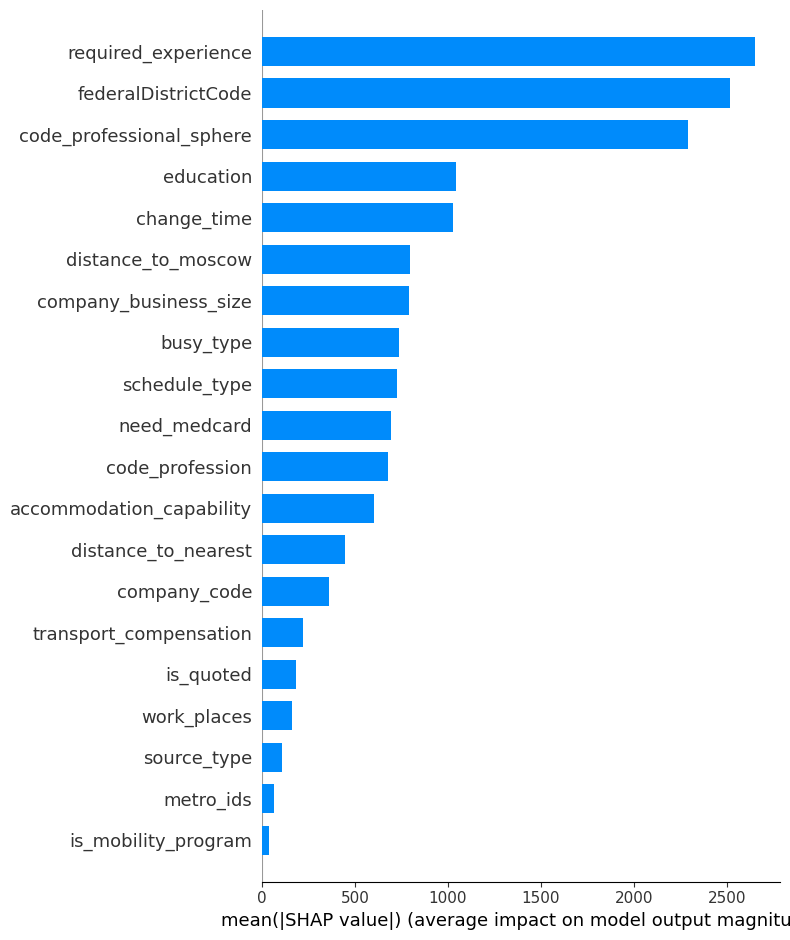

In [88]:
shap_values = explainer.shap_values(X_test.sample(10000))
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.plots.beeswarm(shap_values)

In [89]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Создаем DataFrame с признаками и их важностями
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Importance': mean_abs_shap_values
})

# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=False)

# Печать таблицы
feature_importance_df[feature_importance_df['SHAP Importance'] > 0]['Feature'].values

array(['required_experience', 'federalDistrictCode',
       'code_professional_sphere', 'education', 'change_time',
       'distance_to_moscow', 'company_business_size', 'busy_type',
       'schedule_type', 'need_medcard', 'code_profession',
       'accommodation_capability', 'distance_to_nearest', 'company_code',
       'transport_compensation', 'is_quoted', 'work_places',
       'source_type', 'metro_ids', 'is_mobility_program',
       'retraining_capability', 'required_drive_license'], dtype=object)

In [90]:
y = X['salary']
X = X[feature_importance_df[feature_importance_df['SHAP Importance'] > 0]['Feature'].values]

In [91]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [92]:
model = CatBoostRegressor(
    iterations= 3000,
    learning_rate= 0.05,
    loss_function= 'RMSE',
    cat_features= [],
    verbose=True
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE on test set:", mse)

0:	learn: 17561.8107624	test: 17559.5158448	best: 17559.5158448 (0)	total: 10.4ms	remaining: 31.1s
1:	learn: 17396.6396461	test: 17393.2482814	best: 17393.2482814 (1)	total: 18ms	remaining: 27s
2:	learn: 17246.3616840	test: 17241.7886675	best: 17241.7886675 (2)	total: 26.2ms	remaining: 26.2s
3:	learn: 17108.9936313	test: 17103.3266450	best: 17103.3266450 (3)	total: 33.1ms	remaining: 24.8s
4:	learn: 16985.2401681	test: 16977.8170740	best: 16977.8170740 (4)	total: 40.1ms	remaining: 24s
5:	learn: 16869.0783398	test: 16859.8674281	best: 16859.8674281 (5)	total: 47.1ms	remaining: 23.5s
6:	learn: 16762.0709304	test: 16751.6946256	best: 16751.6946256 (6)	total: 54ms	remaining: 23.1s
7:	learn: 16657.9904421	test: 16646.3881476	best: 16646.3881476 (7)	total: 61.4ms	remaining: 23s
8:	learn: 16565.7677216	test: 16553.4264178	best: 16553.4264178 (8)	total: 68.5ms	remaining: 22.8s
9:	learn: 16477.2816865	test: 16464.1725525	best: 16464.1725525 (9)	total: 75.2ms	remaining: 22.5s
10:	learn: 16394.404

In [105]:
k = 4

print(X_train.iloc[k, :])
print("\n\n\n\n")
print("True salary: ", y_train.iloc[k])
print("Predict salary: ", model.predict(X_train.iloc[k, :]))

required_experience             5.000000
federalDistrictCode             5.000000
code_professional_sphere       14.000000
education                       3.000000
change_time                   -82.000000
distance_to_moscow          10784.293039
company_business_size           0.000000
busy_type                       0.000000
schedule_type                   4.000000
need_medcard                    0.000000
code_profession                      NaN
accommodation_capability        0.000000
distance_to_nearest         15479.311874
company_code                    0.000000
transport_compensation          0.000000
is_quoted                       0.000000
work_places                     1.000000
source_type                     1.000000
metro_ids                       0.000000
is_mobility_program             0.000000
retraining_capability           0.000000
required_drive_license          3.000000
Name: 556641, dtype: float64





True salary:  72000
Predict salary:  70762.70221417598
